In [1]:


import torch
import numpy as np
import matplotlib.pyplot as plt


import libmoon
from libmoon.solver.gradient.methods import EPOSolver
from libmoon.util.prefs import get_uniform_pref
from libmoon.problem.synthetic.mop import BaseMOP

# Set PyTorch to use 32-bit floating-point precision for calculations
torch.set_default_dtype(torch.float32)




In [2]:

def abs_smooth(z, eps: float = 1e-8):
    """
    Smooth absolute value: sqrt(z^2 + eps), differentiable at 0.

    Why:
    ----
    Plain |z| has a kink at 0 (undefined gradient). This smooth version
    avoids that, helping gradient-based methods remain stable thus aiding gradient computation during optimization.

    Parameters
    ----------
    z : torch.Tensor
        Input tensor.
    eps : float
        Small positive smoothing constant.

    Returns
    -------
    torch.Tensor
        Smooth absolute value applied elementwise, computed as sqrt(z^2 + eps).
    """
    return torch.sqrt(z * z + eps)



class XssNewton(torch.autograd.Function):
    """
    Custom PyTorch function to find the steady state (xss) of the ODE using Newton's method:
    backpropagates using the implicit function theorem.

    We solve g(x; alpha, n) = alpha/(1 + x^n) - x = 0 for x.

    Forward:
      Newton iterations on x, starting at x=1, until step size < tol.

    Backward:
      If g(x(alpha,n)) = 0, then by implicit differentiation:
         dx/dalpha = - g_alpha / g_x,
         dx/dn     = - g_n     / g_x
      We assemble these and chain-rule with grad_out.
    """

    @staticmethod
    def forward(ctx, alpha, n, it=30, tol=1e-10):
        """
        Find the steady state (xss) for given alpha and n using Newton's method.

        Args:
            ctx: Context to save tensors for backward pass.
            alpha (torch.Tensor): Parameter controlling production rate.
            n (torch.Tensor): Parameter controlling nonlinearity.
            it (int): Maximum number of iterations (default: 30).
            tol (float): Tolerance for convergence (default: 1e-10).

        Returns:
            torch.Tensor: Steady state value (xss).
        """
        
        x = torch.ones_like(alpha) #### Start near 1.0; any positive value works because the root is unique.
        
        for _ in range(int(it)): #### Iterate to refine x until it satisfies alpha / (1 + x^n) = x
            
            g   = alpha / (1.0 + x.pow(n)) - x  #### Compute ODE value: g = alpha / (1 + x^n) - x
            
            g_x = -1.0 - alpha * n * x.pow(n - 1.0) / (1.0 + x.pow(n)).pow(2.0)  # Compute derivative of g with respect to x

            
            step = g / g_x #### Newton step: Δx = g(x)/g'(x)

            x = x - step #### Update x

            #### check for convergence
            if torch.max(torch.abs(step)) < tol: # Stop when the L-infinity norm of the step or step size is tiny
                break

        # Save tensors for backward pass thus gradient computation
        ctx.save_for_backward(x, alpha, n)
        return x

    @staticmethod
    def backward(ctx, grad_out: torch.Tensor):
        """
        Compute gradients of xss with respect to alpha and n for optimization.
        
        Args:
            ctx: Context with saved tensors (x, alpha, n).
            grad_out (torch.Tensor): Gradient from downstream computations.

        Returns:
            tuple: Gradients with respect to alpha, n, and None for it, tol.
        """
        x, alpha, n = ctx.saved_tensors

        
        
        g_x = -1.0 - alpha * n * x.pow(n - 1.0) / (1.0 + x.pow(n)).pow(2.0) #### g_x = ∂g/∂x. Again, g is the ODE

        
        g_a = 1.0 / (1.0 + x.pow(n)) #### g_alpha = ∂g/∂alpha

        
        #### d/dn [alpha/(1 + x^n)] = -alpha * (x^n * ln x) / (1 + x^n)^2
        g_n = -alpha * x.pow(n) * torch.log(x.clamp_min(1e-12)) / (1.0 + x.pow(n)).pow(2.0) #### g_n = ∂g/∂n   (note the log(x); clamp to avoid log(0))

        #### Chain rule: gradient of output with respect to inputs
        coeff = -grad_out / g_x
        d_alpha = coeff * g_a
        d_n     = coeff * g_n

        return d_alpha, d_n, None, None #### The last two Nones correspond to it and tol, which are not tensors



In [3]:


class SensitivityMOP(BaseMOP):
    """
    Multi-objective problem definition:

    Decision variables:
      z = [alpha, n] with
      alpha ∈ [0.001, 50.0],  n ∈ [0.001, 10.0]

    Objectives (minimize):
      f1 = |S_{alpha, x_ss}| (smooth abs)
      f2 = |S_{n,     x_ss}| (smooth abs)

    Implementation notes:
    - We compute x_ss via XssNewton.apply(alpha, n).
    - We clamp x inside logs via clamp_min to avoid log(0).
    - Return shape: (batch_size, 2)
    """

    def __init__(self, eps = 1e-8):
        super().__init__(n_var=2, n_obj=2, n_cons=0)
        self.problem_name = "ZDT1" 
        self.n_dim = self.n_var = 2  #### Two variables: α and n
        self.n_obj = 2   #### Two objectives: S_α and S_n
        self.lbound = torch.tensor([0.001, 0.001])  #### Lower bounds for [α, n]
        self.ubound = torch.tensor([50.0 , 10.0 ])  #### Upper bounds for [α, n]
        self.eps = float(eps)   #### Numerical stability parameter

    def _evaluate_torch(self, z):
        """
        Evaluate objectives for a batch of candidates.

        Parameters
        ----------
        z (torch.Tensor): Input tensor of shape (batch_size, 2), where each row is [α, n]

        Returns
        -------
        torch.Tensor: Objective values of shape (batch_size, 2), where each row is [S_α, S_n]
        """
        lb = self.lbound.to(z.device)
        ub = self.ubound.to(z.device)

        # Enforce box constraints (keeps the solver well-behaved)
        alpha = z[:, 0].clamp(lb[0], ub[0])
        n     = z[:, 1].clamp(lb[1], ub[1])

        
        x = XssNewton.apply(alpha, n)  #### Find steady state using Newton's method

        #### Calculate first sensitivity objective: S_α
        numerator1 = alpha * (1 + x.pow(n))
        denominator1 = x + alpha * n * x.pow(n) + 2 * x.pow(1+n) + x.pow(1+2*n)
        f1 = abs_smooth(numerator1 / denominator1, self.eps)
        
        #### Calculate second sensitivity objective: S_n
        numerator2 = alpha * n * torch.log(x.clamp_min(1e-12)) * x.pow(n-1)
        denominator2 = 1 + alpha * n * x.pow(n-1) + 2 * x.pow(n) + x.pow(2*n)
        f2 = abs_smooth(-numerator2 / denominator2, self.eps)
        
        
        return torch.stack([f1, f2], dim=1) #### Stack the two objectives into a single tensor 



In [4]:


#### Instantiate the problem
problem = SensitivityMOP(eps=1e-8)

K = 500 #### Number of preference vectors (solutions to find); larger K means more coverage of the Pareto front

prefs = get_uniform_pref(K, 2, clip_eps=1e-2) # Generate uniform preference vectors (weights for objectives); Each row sums to 1. # These encourage coverage of different trade-off directions

# Random initialization across the box (alpha, n)
lb, ub = problem.lbound, problem.ubound
x0 = lb + torch.rand(K, 2) * (ub - lb)

# Gradient-based Pareto optimizer
solver = EPOSolver(
    step_size=1e-1,   #### learning rate for gradient descent or Size of each optimization step (bigger = faster but riskier)
    n_epoch=10,      #### optimization iterations or number of epochs
    tol=1e-6,         #### early-stop threshold inside EPOSolver. Think of it as the tolerance for convergence
    problem=problem,  #### Optimization problem
    prefs=prefs  #### Preference weights
)

# Run optimization
res = solver.solve(x_init=x0)


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


In [ ]:

    # # Extract decision variables and objective values
    # X = res["x"]  # shape (K, 2) : (alpha, n)
    # Y = res["y"]  # shape (K, 2) : (f1, f2)


    # idx = np.argsort(Y[:, 0])   # sort by f1 ascending
    # keep = []
    # best_f2 = np.inf
    # for i in idx:
    #     f2 = Y[i, 1]
    #     if f2 <= best_f2:
    #         keep.append(i)
    #         best_f2 = f2

    # Y_pf = Y[keep]   # Pareto front in objective space
    # # (Optional) X_pf = X[keep]  # corresponding (alpha, n)

   
    # plt.figure(figsize=(8, 6))
    # plt.scatter(Y_pf[:, 0], Y_pf[:, 1], s=12)
    # plt.xlabel(r"$|S_{\alpha,\,x_{ss}}|$")
    # plt.ylabel(r"$|S_{n,\,x_{ss}}|$")
    # plt.title("Pareto Front (libmoon EPOSolver)")
    # plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    # plt.show()


In [ ]:

# import paretoset
# X = res["x"]  # Optimized alpha, n pairs
# Y = res["y"]  # Sensitivities (S_alpha, S_n)



# import numpy as np
# from paretoset import paretoset

# # 'paretoset' expects a matrix of costs. Since we want to minimize both objectives, we can use Y directly.
# # The second argument ['min', 'min'] specifies we are minimizing both columns.
# mask = paretoset(Y, sense=['min', 'min'])

# Y_pf_paretoset = Y[mask]

# # Plot
# plt.figure(figsize=(8,6))
# plt.scatter(Y_pf_paretoset[:, 0], Y_pf_paretoset[:, 1], s=12)
# plt.xlabel("|S_alpha|")
# plt.ylabel("|S_n|")
# plt.title("Pareto Front extracted with paretoset library")
# plt.tight_layout()
# plt.show()

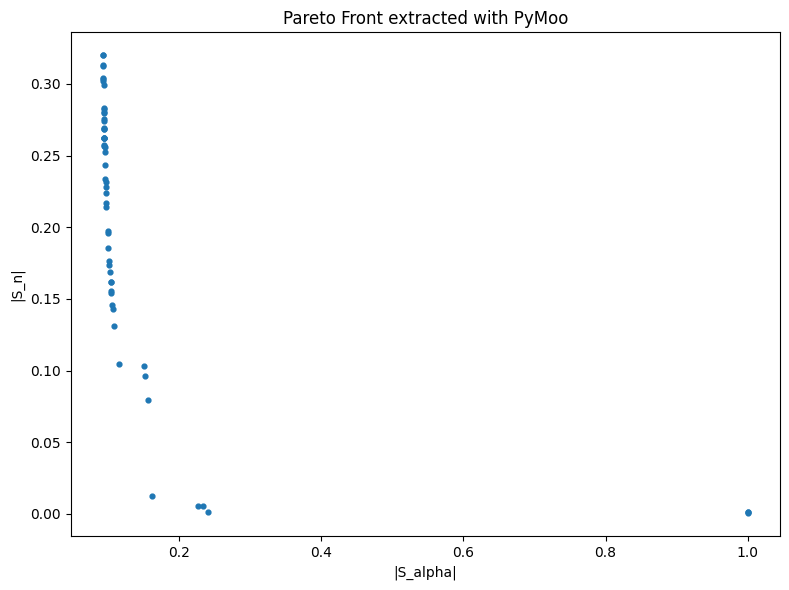

In [5]:


X = res["x"]  # Optimized alpha, n pairs
Y = res["y"]  # Sensitivities (S_alpha, S_n)


from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

#### PyMoo's NonDominatedSorting returns a list of fronts.
#### The first front (index 0) is the true Pareto front.
nds = NonDominatedSorting()
fronts = nds.do(Y, only_non_dominated_front=True) # This returns only the first front

Y_pf_pymoo = Y[fronts]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(Y_pf_pymoo[:, 0], Y_pf_pymoo[:, 1], s=12)
plt.xlabel("|S_alpha|")
plt.ylabel("|S_n|")
plt.title("Pareto Front extracted with PyMoo")
plt.tight_layout()
plt.show()